In [ ]:
#|echo: false
%load_ext autoreload
%autoreload 2

import sys
from fastcore.xtras import Path
# Insert in Path Project Directory
sys.path.insert(0, str(Path().cwd().parent))

## ANATELDB - Descrição 

> A presente biblioteca tem como intuito fazer a extração, limpeza, pós-processamento, validação e verificação de qualidade dos dados presentes nas bases da Anatel.
O fluxo é concentrado nos dados licenciados de serviços públicos de Radiodifusão e Serviços Privados de Telecomunicações que são transmissores de Radiofrequência, excluindo-se por possuir natureza distinta emissões por Satélite e Serviços de Comunicação Multimídia.
Adicionalmente possui rotinas para extração de diversos dados de emissões aeronáuticas utilizando APIs externas 

## BASES DE DADOS

* Instância de Banco de Dados SQL - Server - `ANATELBDRO05`:
  * Base de Dados: `SITARWEB`:
    * `STEL` - Serviços Privados de Telecomunicações    
    Base legada cujos registros, novos e antigos, estão sendo transferidos para o banco de dados `licenciamento` da instância `ANATELBDRO06` 
  * Base de Dados: `SRD`:
    * `RADCOM` - Serviço de Radiodifusão Comunitária
* Instância de Banco de Dados MongoDB - `ANATELBDRO06`:
  * Base de Dados: `srd`:
    * `SRD` - Demais serviços de Radiodifusão, e.g. TV, RTV, RTVD, FM, AM, etc.
  * Base de Dados: `licenciamento`:
    * `TELECOM` - Serviços Privados de Telecomunicações, e.g. Limitado Privado.
  
  Essas bases são referidas coletivamente como `MOSAICO` por conta da plataforma web no qual são acessadas de mesmo nome.
* `AERONAUTICA` - Consolidação de diversas bases de dados públicas da aeronáutica. Esses dados são enriquecidos com informações adicionais fornecidas por órgãos como o DECEA, além de emissões conhecidas provenientes de conhecimento técnico prévio consolidado na agência.

In [ ]:
#|echo: false
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from extracao.constants import MIN_LAT, MAX_LAT, MIN_LONG, MAX_LONG

pasta = Path.cwd().parent / 'dados'

## RADCOM

### Relatório 📝

In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'radcom.parquet.gzip')
for c in ['Latitude', 'Longitude']:
    df[c] = df[c].astype('float')
df['Frequência'] = df['Frequência'].astype('category')
cols = ['Frequência', 'Entidade', 'Fistel', 'Número_Estação', 'Município', 
        'Código_Município', 'Latitude', 'Longitude', 'Classe']
profile = ProfileReport(df.loc[:, cols], config_file='report_config.yaml', title='RADCOM')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Filtragem ✂️

Os únicos filtros efetuados na _query_ para os dados de RADCOM são:
```sql
<...>
where
    SRD.IdtPlanoBasico is not Null 
    and SRD.IndFase is not Null
<...>
``` 
Esse filtro significa que a emissão está licenciada devidamente com o processo de outorga já concluído ou com funcionamento autorizado. A base `RADCOM` possui atualmente possui `4938` registros ativos.

###  Descrição 📊

* `Frequência`: Frequência de Transmissão da Estação
* `Entidade`: Nome da Pessoa (Física | Jurídica) detentora da Outorga
* `Fistel`: Código itentificador da Outorga de Serviço, um Fistel pode conter uma ou mais estações
* `Número_Estação`: Código Identificador da Estação - Código não necessáriamente único, por vezes uma única estação possui diversos transmissores com características distintas
* `Município`: Município de Outorga daquela estação
* `Código_Município`: Código único do IBGE identificando univocamente o município, esse código é utilizado para validar a localização das coordenadas da estação
* `Latitude`
* `Longitude`
* `Classe`: String que identifica o tipo de estação transmissora, no caso de `RADCOM` é a combinação de duas colunas do Banco de Dados: `Fase` e `Situação`

### Pós-Processamento 🛠️


Existem 2 colunas de dados que somente aparecem na base de `RADCOM`:
* `Fase`: Fase do Processo de Licenciamento
* `Situação`: Situação da Outorga

Essas 2 colunas foram combinadas em uma única coluna chamada `Classe`:
* Onde a informação de `Situação` é ausente, a `Classe` é igual a `Fase`: 
    * `3` 
    * `P`
* Onde ambas estão presentes a `Classe` é igual a `<Fase>-<Situação>`:
    * `3-P` 
    * `P-A` 
> Algumas colunas acessórias são criadas para uniformizar os dados ao combiná-los, foram ocultas por simplificação.

### Dados Incorretos 🗑️

A base de `RADCOM` não possui informações de localidade ausentes como Município e Coordenadas. No entanto podemos facilmente checar que existem registros de coordenadas incorretos, fora dos limites do Brasil:

In [ ]:
#| code-fold: true
bad = df[~(df.Latitude.between(MIN_LAT, MAX_LAT) & df.Longitude.between(MIN_LONG, MAX_LONG))]
bad.loc[:, ['Município', 'Código_Município', 'Latitude', 'Longitude']]

Município Código_Município   Latitude  Longitude
62    São Francisco de Paula          4318200 -50.572500 -29.446389
324                 Ipecaetá          2913804  -0.205286  -0.655050
464            Boa Esperança          3201001 -36.535556 -79.833889
631        São Luiz do Norte          5220157 -36.042222 -68.627222
729    São Pedro dos Crentes          2111573  -3.501111  -0.773333
1062         Poços de Caldas          3151800 -45.838889 -21.923611
1249       Ipiranga do Norte          5104526  -0.203989  -0.935672
1310                 Irituia          1503507  -1.771389  -4.437222
2073               Nhandeara          3532603 -20.694167  -5.041111
2349                   Serra          3205002 -52.223611 -40.211389
2404                  Sobral          2312908  -0.062869  -0.674886
3280       Conquista D'Oeste          5103361 -14.537222 -29.546944
3372              Tracuateua          1508035  -0.017892  -0.781681
4724             Suzanápolis          3552551 -20.500833  -1.024444
4819            Campo Grande          5002704  -0.340136  -0.909458

> Uma validação precisa das coordenadas é feita no arquivo final e será descrita posteriormente

## STEL


### Relatório 📝

In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'stel.parquet.gzip')
for c in ['Latitude', 'Longitude']:
    df[c] = df[c].astype('float')
df['Frequência'] = df['Frequência'].astype('category')
cols = ['Frequência', 'Entidade', 'Fistel', 'Número_Estação', 'Município', 
        'Código_Município', 'Latitude', 'Longitude', 'Classe', 'Num_Serviço',
        'Classe_Emissão', 'Largura_Emissão(kHz)']
profile = ProfileReport(df.loc[:, cols], config_file='report_config.yaml', title='STEL')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Filtragem ✂️

A base do `STEL` de estações outorgadas ativas originalmente era muito grande, comportando milhões de registros, nela são efetuados diversos filtros:
```sql
  <...>
where
  HABILITACAO.NumServico <> '010' 
  and ESTACAO.DataExclusao is null  
  and ESTACAO.IndStatusEstacao = 'L' 
  and Municipio.CodMunicipio is not null
  and frequencia.MedTransmissaoInicial is not null 
  and frequencia.CodStatusRegistro = 'L' 
  and contrato.DataValidadeRadiofrequencia is not null 
```

São excluídos do arquivo de retorno:

* Estações do Serviço Móvel Pessoal (SMP - 010)
* Estações excluídas
* Estações com estado distinto de `L - LICENCIADO`
* Estações com o código do município ausente (Necessário para validar a localização)
* Estações sem a frequência de transmissão atribuída 
* Estações cuja frequência atribuída esteja distinta do estado `L - LICENCIADO`
* Estações cuja Validade de Radiofrequência esteja nula

###  Descrição 📊

* `Frequência`: Frequência de Transmissão da Estação
* `Entidade`: Nome da Pessoa (Física | Jurídica) detentora da Outorga
* `Fistel`: Código itentificador da Outorga de Serviço, um Fistel pode conter uma ou mais estações
* `Número_Estação`: Código Identificador da Estação - Código não necessáriamente único, por vezes uma única estação possui diversos transmissores com características distintas
* `Município`: Município de Outorga daquela estação
* `Código_Município`: Código único do IBGE identificando univocamente o município, esse código é utilizado para validar a localização das coordenadas da estação
* `Latitude`
* `Longitude`
* `Classe`: String que identifica o tipo de estação transmissora. (`Fixa, Móvel, etc...`)
* `Num_Serviço`: Código que identifica o Serviço Outorgado na Anatel
* `Classe_Emissão`: `Código que identifica as característica da emissão daquela estação
* `Largura_Emissão(kHz)`: Largura de Banda autorizada para emissão da estação

### Pós-Processamento 🛠️


No caso do `STEL`, temos muitos critérios de Filtragem mas pouco pós-processamento:
* A string `Validade_RF` é filtrada para constar somente a data
* Frequências são normalizadas para a unidade `MHz` 

### Dados Incorretos 🗑️

Como podemos verificar no relatório acima, não existem registros com coordenadas ausentes. No entanto a lista abaixo mostra registros problemáticos com coordenadas incorretas, fora do polígono  do Brasil. Conforme será descrito no arquivo final uma validação precisa de coordenadas usando o formato de cada polígono de município é efetuado em cada registro.

In [ ]:
#| code-fold: true
bad = df[~(df.Latitude.between(MIN_LAT, MAX_LAT) & df.Longitude.between(MIN_LONG, MAX_LONG))]
bad.loc[:, ['Município', 'Código_Município', 'Latitude', 'Longitude']]

Município Código_Município   Latitude  Longitude
249    Cabo de Santo Agostinho          2602902 -34.954194 -14.954194
1811                    Penedo          2706703 -10.286867 -30.562236
2326              Porto Alegre          4314902 -29.990000 -30.079528
2653              Belford Roxo          3300456 -43.401667 -22.734167
5013              Porto Seguro          2925303 -16.440833 -30.081389
7433            Rio de Janeiro          3304557 -43.227500 -22.865000
8649        São João de Meriti          3305109 -43.345278 -22.773333
14655           Rio de Janeiro          3304557 -43.260833 -22.865000
15028           Rio de Janeiro          3304557 -43.231389 -22.890833
17906       São João de Meriti          3305109 -43.345278 -22.773333
20074                  Guamaré          2404507 -36.390586  -5.148578
26307               São Carlos          3548906 -21.033333 -27.966667
27207            São Sebastião          3550704 -45.467519 -23.817844
27723               São Carlos          3548906 -22.033333 -27.966667
35124                   Santos          3548500 -46.297125 -23.986986
36717                  Guamaré          2404507 -36.390586  -5.148578
38135            São Sebastião          3550704 -45.467519 -23.817844
40984                   Santos          3548500 -46.297125 -23.986986
51101                  Guamaré          2404507 -36.390586  -5.148578
52716              Parauapebas          1505536 -49.854553  -6.026131
54078               Terra Nova          2931707 -38.618911 -12.405617
56256              Porto Velho          1100205   9.248617 -64.646650
57667              Parauapebas          1505536 -49.854553  -6.026131
58434                   Passos          3147907 -40.723144 -46.600908
58849              Porto Velho          1100205   9.270789 -64.640611
60270              Porto Velho          1100205   9.245614 -64.646772
62640              Porto Velho          1100205   9.245614 -64.646772
62641              Porto Velho          1100205   9.247097 -64.646789
63393              Porto Velho          1100205   9.270789 -64.640611
64939              Porto Velho          1100205   9.248617 -64.646650
66010              Porto Velho          1100205   9.269350 -64.642775
66608              Porto Velho          1100205   9.247097 -64.646789
66614              Porto Velho          1100205   9.269350 -64.642775

> Uma validação precisa das coordenadas é feita no arquivo final e será descrita posteriormente

## MOSAICO - SRD

In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'srd.parquet.gzip')
for c in ['Latitude', 'Longitude']:
    df[c] = df[c].astype('float')
df['Frequência'] = df['Frequência'].astype('category')
cols = ['Frequência', 'Entidade', 'Fistel', 'Número_Estação', 'Município', 
        'Código_Município', 'Latitude', 'Longitude', 'Classe', 'Num_Serviço']
profile = ProfileReport(df.loc[:, cols], config_file='report_config.yaml', title='SRD - MOSAICO')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Filtragem ✂️

Os filtros efetuados diretamente no banco MongoDB do Mosaico são simples, a _query_ completa ocupa somente 3 linhas:
```python
{
"frequency": {"$nin": [None, "", 0], "$type": 1.0},
"srd_planobasico.CodMunicipio": {"$nin": [None, ""]},
"NumFistel": {"$nin": [None, ""]},
}
```

* Frequências nulas ou zeradas, e exclui registros não numéricos (`"$type": 1.0` )
* Registros com código de município ausente ou inválido ( Necessário para validar as coordenadas)
* Registros com Número do Fistel Nulo ou Inválido


###  Descrição 📊

* `Frequência`: Frequência de Transmissão da Estação
* `Entidade`: Nome da Pessoa (Física | Jurídica) detentora da Outorga
* `Fistel`: Código itentificador da Outorga de Serviço, um Fistel pode conter uma ou mais estações
* `Número_Estação`: Código Identificador da Estação - Código não necessáriamente único, por vezes uma única estação possui diversos transmissores com características distintas. 
  * _Existem também diversos registros sem número de estação, no entanto já com estado de outorga que autoriza o funcionamento._
* `Município`: Município de Outorga daquela estação
* `Código_Município`: Código único do IBGE identificando univocamente o município, esse código é utilizado para validar a localização das coordenadas da estação
* `Latitude`
* `Longitude`
* `Classe`: String que identifica o tipo de estação transmissora. (`A, B, C...`)
* `Num_Serviço`: Código que identifica o Serviço Outorgado na Anatel

> 🤌 Não existem informações no MOSAICO - SRD de `Classe_Emissão` e tampouco `Largura_de_Emissão`

### Pós-Processamento 🛠️


* São mantidas somente estações nos estados autorizados a operar: `C1, C2, C3, C4, C7, C98`
* Normalizada as frequências para a unidade `MHz`
* Imputada `Largura_de_Emissão(kHz)`, e.g. `256kHz` para o canal estéreo de FM, `6M` para TV Digital etc. 
    > Apesar de não constar esses dados na base, os valores de referência são conhecidos pela natureza do Serviço.

### Dados Incorretos 🗑️

Os dados do MOSAICO - SRD são bastante incompletos em relação às coordenadas, praticamente metade dos registros após a filtragem e pós-processamento não possuem latitude e/ou longitude. No entanto esses dados não são excluídos deliberadamente porque nesses registros serão imputados as coordenadas centrais do município no qual se encontram na etapa de validação de coordenadas. 

In [ ]:
#| code-fold: true
bad = df[~(df.Latitude.between(MIN_LAT, MAX_LAT) & df.Longitude.between(MIN_LONG, MAX_LONG))]
bad.loc[:, ['Município', 'Código_Município', 'Latitude', 'Longitude']]

Município Código_Município  Latitude  Longitude
0                 Cruzeiro do Sul          1200203       NaN        NaN
1                     Mâncio Lima          1200336       NaN        NaN
16                   Caldas Novas          5204508       NaN        NaN
17                   Caldas Novas          5204508       NaN        NaN
25     Santa Quitéria do Maranhão          2110104       NaN        NaN
...                           ...              ...       ...        ...
30359                     Codajás          1301308       NaN        NaN
30360                   Parintins          1303403       NaN        NaN
30361                     Piacatu          3537701       NaN        NaN
30362             Espigão D'Oeste          1100098       NaN        NaN
30363                       Natal          2408102       NaN        NaN

[15216 rows x 4 columns]

## MOSAICO - TELECOM

In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'telecom.parquet.gzip')
for c in ['Latitude', 'Longitude']:
    df[c] = df[c].astype('float')
df['Frequência'] = df['Frequência'].astype('category')
cols = ['Frequência', 'Entidade', 'Fistel', 'Número_Estação', 'Município', 
        'Código_Município', 'Latitude', 'Longitude', 'Classe', 'Num_Serviço',
        'Largura_Emissão(kHz)', 'Classe_Emissão', 'Multiplicidade']
profile = ProfileReport(df.loc[:, cols], config_file='report_config.yaml', title='SRD - TELECOM')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Filtragem ✂️

A _query_ do MongoDB para a base LICENCIAMENTO é listada e descrita a seguir

```python
{"DataExclusao": None},
{"DataValidade": {"$nin": ["", None]}},
{"Status.state": "LIC-LIC-01"},
{"NumServico": {"$nin": ["010", "045", "171", "450", "750", "", None]}},
{"FreqTxMHz": {"$nin": [None, "", 0]}},
{"CodMunicipio": {"$nin": [None, ""]}},
{"FreqTxMHz": {"$type": 1.0}},
{"Latitude": {"$type": 1.0}},
{"Longitude": {"$type": 1.0}}
```

* Registros cuja data de exclusão é Nula, i.e. registros ativos
* Data de Validade de Radiofrequência não nula ou vazia
* Estado `Licenciado`
* Excluir Serviços não contemplados pelos Planos de Monitoração atualmente, por exemplo `010 - SCM` 
* Frequência de Transmissão não nula, zerada ou vazia
* Código de Município não nulo ou vazio
* Frequência de Transmissão no formato numérico (eliminar registros com caracteres e texto)
* Latitude no formato numérico
* Longitude no formato numérico

###  Descrição 📊
A base do MOSAICO - TELECOM é de longe a maior atualmente com milhões de registros ativos.

* `Frequência`: Frequência de Transmissão da Estação
* `Entidade`: Nome da Pessoa (Física | Jurídica) detentora da Outorga
* `Fistel`: Código itentificador da Outorga de Serviço, um Fistel pode conter uma ou mais estações
* `Número_Estação`: Código Identificador da Estação - Código não necessáriamente único, por vezes uma única estação possui diversos transmissores com características distintas
* `Município`: Município de Outorga daquela estação
* `Código_Município`: Código único do IBGE identificando univocamente o município, esse código é utilizado para validar a localização das coordenadas da estação
* `Latitude`
* `Longitude`
* `Classe`: String que identifica o tipo de estação transmissora. (`Fixa, Móvel, etc...`)
* `Num_Serviço`: Código que identifica o Serviço Outorgado na Anatel
* `Classe_Emissão`: `Código que identifica as característica da emissão daquela estação
* `Largura_Emissão(kHz)`: Largura de Banda autorizada para emissão da estação
* `Multiplicidade`: Contador do número de estações similares:
    * Existem registros com todas as características anteriores idênticas, exceto o `Número_Estação` por exemplo. 
    * Estações possuem detalhes técnicos que não são considerados relevantes, pelo menos no escopo atual, para a Análise Espectral e Identificação de Emissões - como por exemplo:
        * Tipo de Antena
        * Polarização: Horizontal ou Vertical.
        * Altura da Antena
        * Potência de Transmissão
    
    A seguir é mostrado um exemplo de estação desse tipo, com **201** estações com características técnicas idênticas conforme o quesito descrito no parágrafo anterior:
    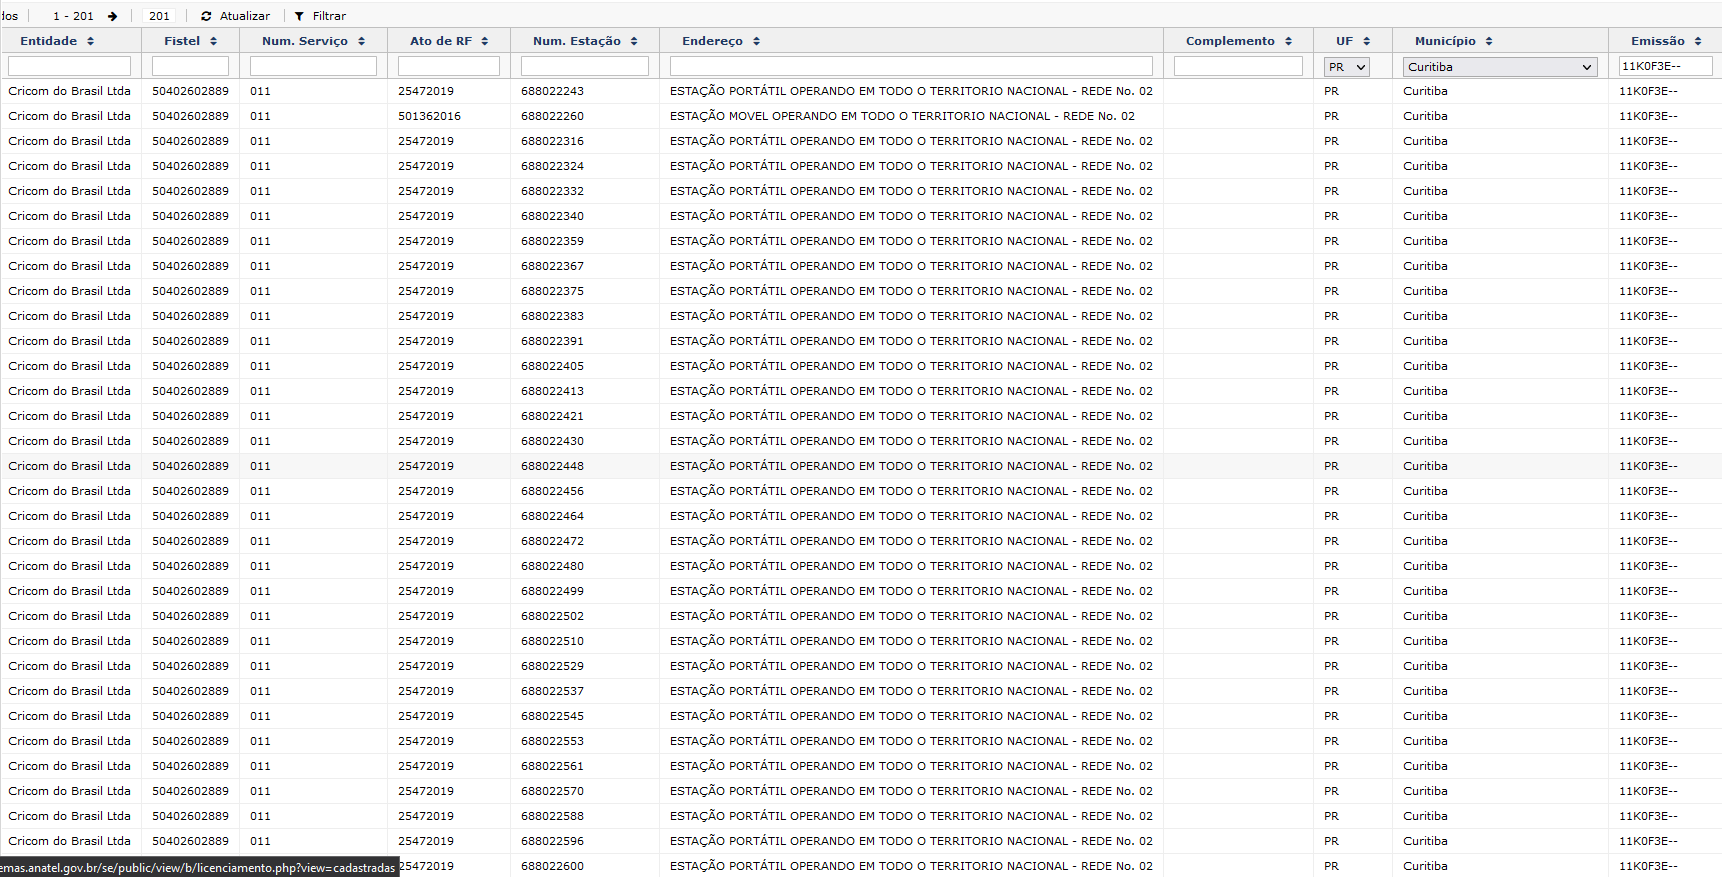
    > Esses registros são considerados idênticos e são agrupados. É utilizado o primeiro número de estação que aparece na base como referência e o total de estações "idênticas" é registrado na coluna multiplicidade: **1 para estações "únicas" e qualquer valor maior que 1 descreve o número de estações similares à listada**:
    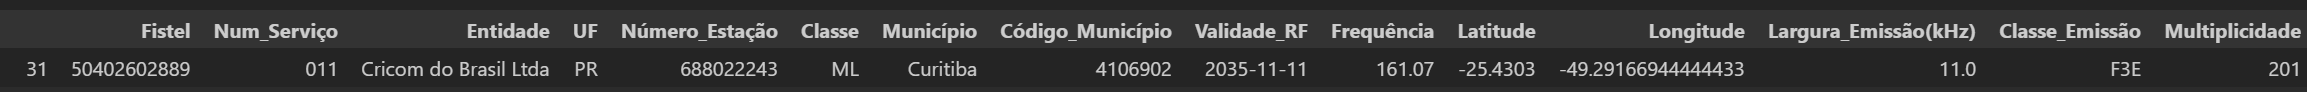

### Pós-Processamento 🛠️


O pós-processamento do MOSAICO - LICENCIAMENTO é mais complexo por conta das escolhas na modelagem do Banco e faz uso extenso de funções da biblioteca `pandas`

* A string `Emissão` é a concatenação das colunas `Largura_Emissão` e `Classe_Emissão` como constavam no STEL. Além do mais existem estações com múltiplas strings de `Emissão` na mesma coluna separadas por vírgula, os passos de processamento dessa colunas são os seguintes:
    * Eliminação de espaços e normalização para maiúscula
    * Expansão dos múltiplos registros separados por vírgula em linhas individuais, 1 por linha com as demais informações idênticas
    * Processamento de cada string `Emissão` concatenada nas duas partes atômicas: `Largura_Emissão` e `Classe_Emissão`
* Agrupamento de estações similares em um único registro, conforme descrito no parágrafo anterior e criação da coluna `Multiplicidade`
> Atualmente esse agrupamento restringe o arquivo final para somente 10% do tamanho dos registros originais, tornando o espaço de busca mais eficiente.



## AERONÁUTICA 🛬

Além de prover uma API que extrai, limpa, processa e padroniza os dados de estações licenciadas na Anatel - relevantes para a Identificação de Emissões no âmbito dos Planos de Monitoração -  Outro diferencial são os dados adicionais de emissões aeronáuticas extraídos e consolidados provenientes de diversas fontes, em sua maioria sem registro "oficial" na Anatel.

As fontes de dados aeronáuticos são:

* ICAO - Através do Software [_Frequency Finder_](https://www.icao.int/safety/FSMP/Documents/Forms/AllItems.aspx?RootFolder=%2fsafety%2ffsmp%2fdocuments%2ffrequencyfinder&FolderCTID=0x012000B1461A5DA8C64241AA4DE4F91CB1D9AF%20%E2%80%8B) são filtradas e exportadas as emissões do Brasil
* [API do AISWEB](https://documenter.getpostman.com/view/7201070/SzKQyg3H)
    * Todos as emissões de Aeródromos Públicos e Militares
* [API do GEOAISWEB](https://geoaisweb.decea.mil.br/)
    * Emissões do tipo `VOR`, `NDB` e `DME`
* [API do REDEMET](https://ajuda.decea.mil.br/base-de-conhecimento/api-redemet-produtos-radar/)
    * Especificamente dados de radares meteorológicos
* Arquivo de Radares
    * Dados adicionais de Radares Secundários nas frequências `1030MHz` e `1090MHz` com frequência e localização conhecida, disponível por documentação interna.
* Arquivo de Canalização
    * Este arquivo, também criado por meio de documentação interna, mapeia os canais das frequências do tipo `VOR_ILSLoc`, nas frequências adicionais `ILS glide`, `DME Airborne` e `DME Ground`. 

    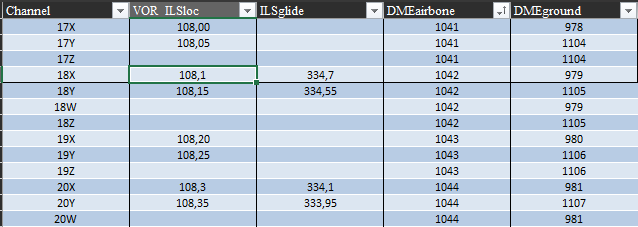

    > Os registros presentes nas bases da aeronáutica, normalmente somente contém registros das frequências `VOR_ILSLoc`, no entanto para os canais listados normalmente as demais frequências estão presentes e como parte do pós-processamento essas frequências são imputadas mantendo a mesma descrição e localização.

### Pós-Processamento


Não cabe descrever aqui como é implementado o código para consumir as APIs, alguns são um tanto complexos como o AISWEB, para tal basta consultar a documentação ou investigar diretamente os módulos python no entanto o processamento resultante é simples de descrever:

* Mapeamento das frequências `VOR_ILSLoc` no arquivo de canais. As frequências adicionais presentes nos canais são adicionadas no arquivo final.
* Como existe sobreposição de registros, i.e. as bases não são individualizadas, os registros são mapeados entre si e caso estejam a uma distância menor que uma distância de referência ( normalmente uma margem bem ampla de `10Km` ou `20Km`) os registros são mesclados, mantendo-se a coordenada do registro original do `icao` e a descrição de ambos é concatenada.  

In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'aero.parquet.gzip')
for c in ['Latitude', 'Longitude']:
    df[c] = df[c].astype('float')
df.loc[np.isclose(df.Longitude, -472.033447), 'Longitude'] = -47.2033447
df.loc[np.isclose(df.Longitude, 69.934998), 'Longitude'] = -69.934998
df['Frequency'] = df['Frequency'].astype('category')
profile = ProfileReport(df, config_file='report_config.yaml', title='DADOS AERONÁUTICOS')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Validação de Coordenadas ✅

In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'base.parquet.gzip')
for c in ['Latitude', 'Longitude']:
    df[c] = df[c].astype('float')
df['Frequência'] = df['Frequência'].astype('category')
cols = ['Frequência', 'Entidade', 'Fistel', 'Número_Estação', 'Município', 
        'Código_Município', 'Latitude', 'Longitude', 'Classe', 'Num_Serviço']
profile = ProfileReport(df, config_file='report_config.yaml', title='Base - Licenciados')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Vimos superficialmente nos parágrafos anteriores que além haver muitos registros sem coordenadas - como no MOSAICO - SRD - muitas coordenadas não são válidas, seja por inversão de sinal, lugar incorreto do divisor decimal, inversão da Latitude com a Longitude ou simplesmente não correspondem ao município no qual estão licenciadas.

Os passos para validar as informações de localização são:

* Os arquivos descritos anteriormente são concatenados, exceto os dados da aeronáutica por não conter o `Código_Município`
* Os registros com `Código_Município` ausentes são excluídos - este dado é necessário para validar se a coordenadas estão contidas corretamente no município.
* As dados de localização - a saber `Código_Município`, `Latitude`, `Longitude` -  são repassados para uma _query_ SQL que busca na base `CORPORATIVO.dbo.TB_IBGE_MUNICIPIO` e checa **se as coordenadas estão contidas no polígono característico descrito pelo `Código_Município`**, retornando `Verdadeiro` caso positivo e `Falso` caso contrário:

```sql
    SELECT 
        mun.NO_MUNICIPIO 
        , mun.NU_LONGITUDE 
        , mun.NU_LATITUDE         
        , CONVERT(int, 
            (mun.GE_POLIGONO.STIntersects(geometry::STGeomFromText(
                'POINT({} {})', 
                mun.GE_POLIGONO.STSrid)
            )) 
        )AS COORD_VALIDA
    FROM 
        CORPORATIVO.dbo.TB_IBGE_MUNICIPIO mun
    WHERE
        MUN.CO_MUNICIPIO = {}
```
    
* Além disso são retornados o nome padronizado do `Município` e suas coordenadas como registrado oficialmente no IBGE

## Arquivo Final🗄️


O Arquivo final disponibilizado para as atividades de monitoração é formatado da seguinte forma

* Arquivo base com os dados da Anatel com as seguintes colunas:
    * `Frequência`
    * `Número_Serviço`
    * `Número_Estação`
    * `Classe_Emissão`
    * `Largura_Emissão(kHz)`

* Para simplificação de como os dados são apresentados, é criada a coluna `Descrição` com as seguintes colunas aglutinadas:
    * `Fonte` - _Qual das bases acima é originário o registro_
    * `Status`
    * `Classe`
    * `Entidade`
    * `Fistel`
    * `#Estação` - `Número_Estação`+ `Multiplicidade`
    * `Município_IBGE`
    * `UF`
    
    A coluna `Município` é substituída pela coluna `Município_IBGE`, por esta estar completa e validada através do `Código_Município`
    * Os registros que não possuem coordenadas ou estas foram considerados inválidas têm suas coordenadas substituídas pela coordenada do município.
    > Esses registros são identificados com o sinal `*` ao final da coluna `Descrição`.
* Arquivo pós-processado com os dados aeronáuticos
* Mesclagem dos dados aeronáuticos com os registros da Anatel, nos mesmos moldes que os dados aeronáuticos foram mesclados entre si. Nesse caso os dados da Anatel são mantidos e a Descrição da estação aeronáutica concatenada com a Descrição da estação da Anatel.
* Adição de uma coluna numérica identificadora da emissão: `#1, #2, #3, ...` 

In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'AnatelDB.parquet.gzip')
for c in ['Latitude', 'Longitude']:
    df[c] = df[c].astype('float')
df.loc[np.isclose(df.Longitude, -472.033447), 'Longitude'] = -47.2033447
df.loc[np.isclose(df.Longitude, 69.934998), 'Longitude'] = -69.934998
for c in df.columns[3:]:
    df[c] = df[c].astype('category')
profile = ProfileReport(df, config_file='report_config.yaml', title='Arquivo Final')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]